In [34]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists
%matplotlib inline
import matplotlib; matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
import matplotlib.pyplot as plt

from model import FullyConnected, BayesianRegression
from viz import plot_1d_posterior_predictive
from util import (
    ftens_cuda,
    to_np,
    cuda_available,
    add_output_noise,
    train_objective,
)

def get_coverage_bounds(posterior_pred_samples, percentile):
    '''
    Assumes N x samples
    '''
    assert(not (percentile < 0. or percentile > 100.))

    lower_percentile = (100.0 - percentile) / 2.0
    upper_percentile = 100.0 - lower_percentile

    upper_bounds = np.percentile(posterior_pred_samples, upper_percentile, axis=-1)
    lower_bounds = np.percentile(posterior_pred_samples, lower_percentile, axis=-1)

    return lower_bounds, upper_bounds

def plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred):
    assert(len(x_train.shape) == 2 and x_train.shape[-1] == 1)
    assert(len(y_train.shape) == 2 and y_train.shape[-1] == 1)
    assert(len(x_viz.shape) == 2 and x_viz.shape[-1] == 1)    
    assert(len(y_pred.shape) == 2 and y_pred.shape[0] == x_viz.shape[0])

    # make sure x_viz is sorted in ascending order
    x_viz = to_np(x_viz.squeeze())
    assert(np.all(x_viz[:-1] <= x_viz[1:]))
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # plot predictive intervals
    for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
        lower, upper = get_coverage_bounds(to_np(y_pred), picp)
        ax.fill_between(
            x_viz, lower, upper, label='{}%-PICP'.format(picp), color='steelblue', alpha=alpha,
        )

    # plot predictive mean
    pred_mean = to_np(torch.mean(y_pred, -1))        
    ax.plot(x_viz, pred_mean, color='blue', lw=3, label='Predictive Mean')

    # plot training data
    ax.scatter(x_train, y_train, color='red', s=10.0, zorder=10, label='Training Data')

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')    
    ax.set_title('Posterior Predictive')
    ax.legend()
    
    # plt.tight_layout()
    plt.show()

# OUTPUT_DIR = 'output'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
        
# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# set training data
N = 20
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.2).sample((N//2, 1)), dists.Uniform(0.2, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)

# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 50000

# architecture and activation
ACTIVATION = nn.LeakyReLU
layers = [1, 200, 200, 1]

# define a neural network feature basis and final layer
basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

# define MLE loss
def mle_loss():
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
    
    return loss, (basis, final_layer)

# 1) Geoff
## Architecture (depth, width, size) affect uncertainty?
## Prior (weight initialization and prior on the bayesian part) affect uncertainty>
# Hypothesis 1: Deeper -> less variation in the functions -> less good uncertainty
# Hypothesis 2: Wider -> more variation in the functions (??) -> better uncertainties

### Papers about Bayesian Deep Ensembles..
## Bayesian Deep Ensembles via the Neural Tangent Kernel

# 2) Lucy
## Regularization (MAP) - code up MAP and Maximum Marginal Likelihood from UNA

### Papers about GP's, joint learning

# 3) Max
## Visualizing these bases (?)
## Compare bases for regimes of good/poor uncertainties
# Good uncertainties -> more variety in the basis
# Bad uncertainties -> every basis function is similar

### Paper about An Empirical Study on The Properties of Random Bases for Kernel Methods

In [35]:
# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

# This step trains the deterministic NN fully to get the basis functions
# for Luna we need to change the mle loss to, the part of the MLE loss that we need to change is the y_train I believe.

# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    mle_loss,
    lr=LEARNING_RATE,
    print_freq=1000
)

# This is just bayesian linear regression with pretrained kernel
# infer posterior over the last layer weights given the basis
model.infer_posterior(basis(x_train), y_train)

# sample from posterior predictive
x_viz = ftens_cuda(np.linspace(-2.0, 2.0, 500)).unsqueeze(-1)
y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

# visualize posterior predictive

Epoch 0: loss = 3341.0495886968506
Epoch 1000: loss = 0.02033155843483531
Epoch 2000: loss = 0.009885729282261653
Epoch 3000: loss = 0.0042899425842666
Epoch 4000: loss = 0.10817982174322607
Final Loss = 0.0021020234463841685


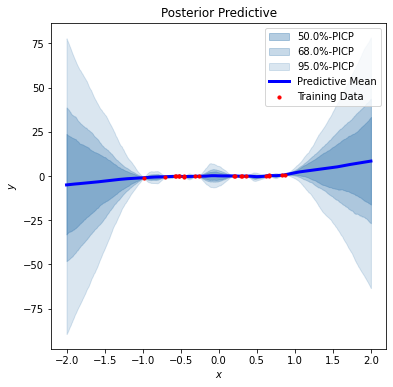

In [36]:
%matplotlib inline
plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)

In [ ]:
# run nlm on small/ large models and compare uncertainties
def nlm(w_prior_var = 1.0,output_var = 0.01, LEARNING_RATE = 0.001, EPOCHS = 20000, layers = [1, 50, 50, 1] ):
    # if not os.path.exists(OUTPUT_DIR):
    #     os.makedirs(OUTPUT_DIR)
        
    # define model
    #w_prior_var = 1.0 # variance of prior over weights
    #output_var = 0.01 # variance of observation noise
    model = BayesianRegression(w_prior_var, output_var)
    
    # set training data
    N = 100
    x_train = dists.Uniform(-1.0, 1.0).sample((N, 1))
    y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)
    
    # parameters of optimizer
    # LEARNING_RATE = 0.001
    # EPOCHS = 20000

    # architecture and activation
    ACTIVATION = nn.LeakyReLU
    #layers = [1, 50, 50, 1]
    
    # define a neural network feature basis and final layer
    basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
    final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

    # define MLE loss
    def mle_loss():
        y_pred = final_layer(basis(x_train))
        loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
        
        return loss, (basis, final_layer)

    # randomly initialize basis and last layer
    basis.rand_init(math.sqrt(w_prior_var))
    final_layer.rand_init(math.sqrt(w_prior_var))

    # optimize loss to learn network
    (basis, final_layer), loss = train_objective(
        list(basis.parameters()) + list(final_layer.parameters()),
        mle_loss,
        lr=LEARNING_RATE,
        print_freq=1000
    )

    # infer posterior over the last layer weights given the basis
    model.infer_posterior(basis(x_train), y_train)

    # sample from posterior predictive
    x_viz = ftens_cuda(np.linspace(-2.0, 2.0, 500)).unsqueeze(-1)
    y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

    # visualize posterior predictive
    plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)

layers_choices = [[1,8,8,1],[1, 50, 50, 1], [1,128,128,1] ]

for layer_structure in layers_choices:
    nlm(layers = layer_structure)


Epoch 0: loss = 45.63502449352075
Epoch 1000: loss = 0.1118633733244334
Epoch 2000: loss = 0.022054911764685502
Epoch 3000: loss = 0.01399863120505938
Epoch 4000: loss = 0.011836384353130171
Final Loss = 0.01069270151395262
Epoch 0: loss = 480.57033341726964
Epoch 1000: loss = 0.03782176536821133
Epoch 2000: loss = 0.019220374550074595
Epoch 3000: loss = 0.012578406067195673
Epoch 4000: loss = 0.009658268698206277
Final Loss = 0.008385320992461458
Epoch 0: loss = 1016.1193130013327
Epoch 1000: loss = 0.03149682058055268
Epoch 2000: loss = 0.01569619036899101
Epoch 3000: loss = 0.009516273921633168
Epoch 4000: loss = 0.008096409448551748
Final Loss = 0.00732323180447969


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c42157bc-f2b8-432a-aeaf-313aea189abc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>